In [218]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [219]:
batch_size = 64
learnin_rate = 0.00005
num_epochs = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [220]:
print(torch.cuda.is_available())

print(torch.__version__)

True
2.1.2+cu121


In [221]:
dataset = torch.load('images_perso.pth')
labels = torch.load('labels_perso.pth')
size_input=dataset[1].shape
label_size=labels[1].shape
input_size=np.asarray((size_input[2],size_input[1],size_input[0]))
num_classes = label_size[0]
print(input_size)
print(num_classes)

[128 128   3]
3


In [222]:
class handDataset(torch.utils.data.Dataset):

    def __init__(self):
        self.x = dataset
        self.y = labels
        self.n_samples = len(dataset)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [223]:
generator = torch.Generator().manual_seed(42)

train_size = int(len(dataset) * .7)
test_size = len(dataset) - train_size

hand_dataset = handDataset()
train_dataset, test_dataset = torch.utils.data.random_split(hand_dataset, [train_size, test_size], generator=generator)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [224]:
class FF_model(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*64*3,500) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)  
    
    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [225]:
class CNN_model(nn.Module):

    def __init__(self, num_classes):
        super(CNN_model, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        size=input_size-3+1
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)
        size=size/2
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        size=size-3+1
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.5)
        size=size/2

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(int(size[0])*int(size[1])*64,128)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out=self.relu1(out)
        out = self.max_pool1(out)
        out = self.conv_layer2(out)
        out=self.relu2(out)
        out = self.max_pool2(out)
        out=self.dropout1(out)
        out = self.flatten(out)
        #896x14 and 12544x128)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.dropout2(out)
        out = self.fc2(out)

        return out


In [226]:
cnn_model = CNN_model(num_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learnin_rate, weight_decay=0.005, betas=(0.9, 0.999))

total_step = len(train_loader)

In [227]:
Loss_train=[]
Loss_test=[]
for epoch in range(num_epochs):
    sum_loss_train = 0
    total_train=0
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images=images.to(device)
        labels=labels.to(device)
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        sum_loss_train+=loss.item()
        total_train+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        sum_loss_test = 0
        total = 0
        for images, labels_test in test_loader:
            images=images.to(device)
            labels_test=labels_test.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels_test)
            sum_loss_test+=loss.item()
            #add 1 to the totalto mean the loss over all the test_dataset
            total += 1
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, sum_loss_train/total_train))
    Loss_train.append(sum_loss_train/total_train)
    Loss_test.append(sum_loss_test/total)


43it [00:01, 24.37it/s]


Epoch [1/40], Loss: 1.0667


43it [00:01, 30.13it/s]


Epoch [2/40], Loss: 0.9956


43it [00:01, 29.89it/s]


Epoch [3/40], Loss: 0.9245


43it [00:01, 30.18it/s]


Epoch [4/40], Loss: 0.8757


43it [00:01, 30.21it/s]


Epoch [5/40], Loss: 0.8270


43it [00:01, 30.21it/s]


Epoch [6/40], Loss: 0.7735


43it [00:01, 30.19it/s]


Epoch [7/40], Loss: 0.7326


43it [00:01, 30.22it/s]


Epoch [8/40], Loss: 0.7008


43it [00:01, 30.21it/s]


Epoch [9/40], Loss: 0.6663


43it [00:01, 30.19it/s]


Epoch [10/40], Loss: 0.6200


43it [00:01, 30.16it/s]


Epoch [11/40], Loss: 0.6045


43it [00:01, 30.10it/s]


Epoch [12/40], Loss: 0.5654


43it [00:01, 30.20it/s]


Epoch [13/40], Loss: 0.5323


43it [00:01, 30.05it/s]


Epoch [14/40], Loss: 0.5058


43it [00:01, 29.92it/s]


Epoch [15/40], Loss: 0.4827


43it [00:01, 30.10it/s]


Epoch [16/40], Loss: 0.4614


43it [00:01, 30.06it/s]


Epoch [17/40], Loss: 0.4454


43it [00:01, 30.09it/s]


Epoch [18/40], Loss: 0.4236


43it [00:01, 30.12it/s]


Epoch [19/40], Loss: 0.3937


43it [00:01, 29.97it/s]


Epoch [20/40], Loss: 0.3899


43it [00:01, 30.03it/s]


Epoch [21/40], Loss: 0.3681


43it [00:01, 30.03it/s]


Epoch [22/40], Loss: 0.3593


43it [00:01, 30.11it/s]


Epoch [23/40], Loss: 0.3337


43it [00:01, 30.02it/s]


Epoch [24/40], Loss: 0.3188


43it [00:01, 30.00it/s]


Epoch [25/40], Loss: 0.3116


43it [00:01, 29.97it/s]


Epoch [26/40], Loss: 0.2883


43it [00:01, 30.03it/s]


Epoch [27/40], Loss: 0.2871


43it [00:01, 29.97it/s]


Epoch [28/40], Loss: 0.2711


43it [00:01, 30.02it/s]


Epoch [29/40], Loss: 0.2660


43it [00:01, 29.98it/s]


Epoch [30/40], Loss: 0.2443


43it [00:01, 29.99it/s]


Epoch [31/40], Loss: 0.2393


43it [00:01, 29.94it/s]


Epoch [32/40], Loss: 0.2268


43it [00:01, 30.02it/s]


Epoch [33/40], Loss: 0.2233


43it [00:01, 30.07it/s]


Epoch [34/40], Loss: 0.2257


43it [00:01, 30.04it/s]


Epoch [35/40], Loss: 0.2073


43it [00:01, 29.98it/s]


Epoch [36/40], Loss: 0.1988


43it [00:01, 30.01it/s]


Epoch [37/40], Loss: 0.1912


43it [00:01, 29.94it/s]


Epoch [38/40], Loss: 0.1771


43it [00:01, 29.95it/s]


Epoch [39/40], Loss: 0.1864


43it [00:01, 29.94it/s]


Epoch [40/40], Loss: 0.1679


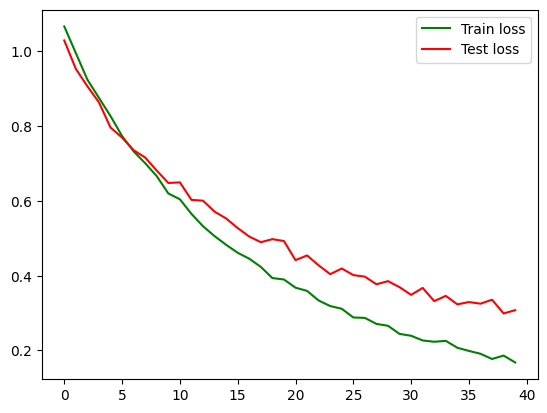

In [228]:
X= [ i for i in range(len(Loss_train)) ]
plt.plot(X,Loss_train,color="green",label="Train loss")
plt.plot(X,Loss_test,color="red",label="Test loss")
plt.legend()
plt.show()

In [229]:

with torch.no_grad():
    correct = 0
    total = 0
    start = timer()
    for images, labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs = cnn_model(images)
        #predicted renvois un tenseur de la taille du bactn qui contient la valeur prédite pour chaque input
        _, predicted = torch.max(outputs.data, 1)
        #labels.size(0) return the size of the batch to add each inference of the batch to the total
        total += labels.size(0)
        #labels_class est un tenseur de la taille du batch qui contient le label pour chaque input du batch
        labels_class=torch.max(labels,1)
        for i,sample in enumerate(labels_class[1]):
            if sample==predicted[i]:
                correct += 1
    end=timer()
    
    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))
    print("Time of inference =" + str((end-start)/total) +"s")



Accuracy of the network on the 1173 test images: 90.02557544757033 %
Time of inference =0.00029289769822571235s


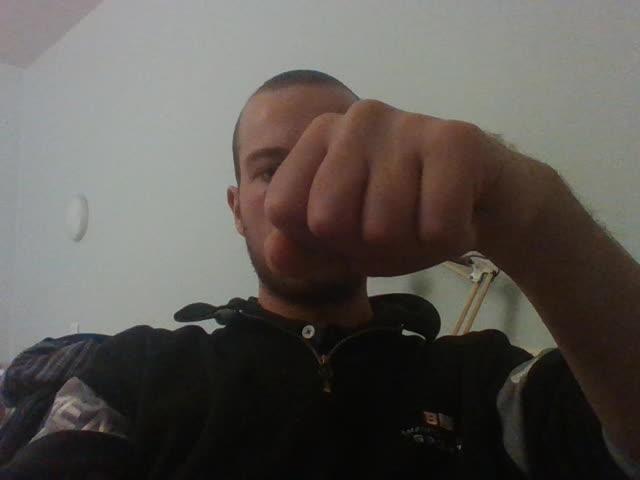

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x26880 and 57600x128)

In [231]:
from PIL import Image
tr = transforms.Compose([
        transforms.Resize((128, 64)),
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(),  
        #transforms.RandomRotation(90),  
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
        transforms.Normalize(mean=[0], std=[0.5])  # Normalizing mean and std values
    ])
image = Image.open("./validation/poing.jpeg").convert('RGB')
display(image)
image_tensor = tr(image)
image_tensor=image_tensor.to(device)
image_batch = image_tensor.unsqueeze(0)
predicted=cnn_model(image_batch)
print(predicted)


## Sauvegarde du modèle

In [ ]:
model_scripted = torch.jit.script(cnn_model) # Export to TorchScript
model_scripted.save('sauvegarde.pt') # Save